In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [2]:
df_train = pd.read_csv("./data/train.csv",dtype={'일시':int})

In [3]:
df_train.head()

,일시,광진구,동대문구,성동구,중랑구
0,20180101,0.592,0.368,0.580,0.162
1,20180102,0.840,0.614,1.034,0.260
2,20180103,0.828,0.576,0.952,0.288
3,20180104,0.792,0.542,0.914,0.292
4,20180105,0.818,0.602,0.994,0.308


<AxesSubplot:>

c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44305 (\N{HANGUL SYLLABLE GWANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\

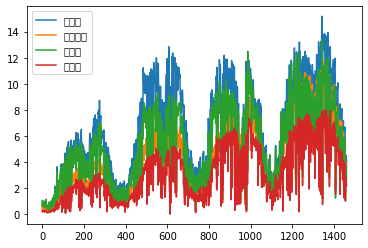

In [4]:
df_train.iloc[:,1:].plot()

<AxesSubplot:>

c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44305 (\N{HANGUL SYLLABLE GWANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\

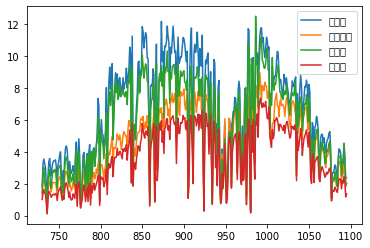

In [5]:
df_train[(df_train['일시'] >= 20200101) & (df_train['일시'] < 20210001)].iloc[:,1:].plot()

In [6]:
def dfByDateRange(dt_start:datetime,dt_end:datetime):
    dts=[]
    dt_cur = dt_start
    while dt_cur <= dt_end:
        dts.append(dt_cur.year*10000 + dt_cur.month*100 + dt_cur.day)
        dt_cur += timedelta(days=1)

    return pd.DataFrame({'일시': dts})

In [7]:
def preprocess(df,holiday_path,makeY=False):
    df_holiday =  pd.read_csv(holiday_path,dtype={'locdate':int})

    holidays = df_holiday['locdate'].apply(lambda x : datetime(year=int(x//1e4), month = int((x%1e4)//100), day=int(x%100)))
    
    df_features = pd.DataFrame()
    df_features['date'] = df['일시'].apply(lambda x : datetime(year=int(x//1e4), month = int((x%1e4)//100), day=int(x%100)))
    df_features['weekday'] = df_features['date'].apply(lambda date : date.weekday())
    df_features['month'] = df_features['date'].apply(lambda date : date.month)
    df_features['day_of_month']= df_features['date'].apply(lambda date : date.day) 
    df_features['day_of_year'] = df_features['date'].apply(lambda date : date.timetuple().tm_yday) 
    df_features['red'] = df_features['date'].isin(holidays) | df_features['weekday'].isin([5,6]) #saturday sunday
    df_features['year'] = df_features['date'].apply(lambda date : date.year)
    df_features['week_of_year']=df_features['date'].apply(lambda date : date.isocalendar()[1])

    df_features['vacation'] = False
    df_features['rainy_season'] = df_features['date'].apply(lambda date : 726 >= date.month*100 + date.day >= 625)

    for i in range(1,df_features.shape[0]-1):
        if df_features["red"][i] & df_features["red"][i-1] & df_features["red"][i+1]:
            df_features.at[i-1,"vacation"] = True
            df_features.at[i,"vacation"] = True
            df_features.at[i+1,"vacation"] = True


    cols_location = ['광진구','동대문구','성동구','중랑구']
    list_df_features_by_loc = []
    for idx, loc in enumerate(cols_location):
        df_new = df_features.copy()
        df_new['loc'] = idx
        if makeY:
            df_new['y']=df[loc]
        list_df_features_by_loc.append(df_new)

    df_ret=pd.concat(list_df_features_by_loc)
    df_ret = df_ret.reset_index(drop=True)

    df_ret = df_ret.drop('date',axis=1)

    return df_ret


In [8]:
df_processed = preprocess(df_train,'./data/holiday_train.csv',makeY=True)

df_trainX = df_processed.drop(['y'],axis=1)
df_trainY = df_processed['y']

In [9]:
df_trainX.tail()

,weekday,month,day_of_month,day_of_year,red,year,week_of_year,vacation,rainy_season,loc
5839,0,12,27,361,False,2021,52,False,False,3
5840,1,12,28,362,False,2021,52,False,False,3
5841,2,12,29,363,False,2021,52,False,False,3
5842,3,12,30,364,False,2021,52,False,False,3
5843,4,12,31,365,False,2021,52,False,False,3


In [11]:
from pygam import LinearGAM,s,f
import matplotlib.pyplot as plt

# gam = LinearGAM(s(0)+s(1)+s(2)+s(3)+f(4)+s(5)+s(6)+f(7)).fit(df_trainX,df_trainY)
gam = LinearGAM(s(0)+s(1)+s(2)+s(3)+f(4)+s(5)+s(6)+f(7)+f(8)+f(9))
gam.gridsearch(df_trainX.values,df_trainY.values)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:02
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:02
 36% (4 of 11) |#########                | Elapsed Time: 0:00:01 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:01 ETA:   0:00:01
 54% (6 of 11) |#############            | Elapsed Time: 0:00:01 ETA:   0:00:01
 63% (7 of 11) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:01
 72% (8 of 11) |##################       | Elapsed Time: 0:00:02 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:02 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:02 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + f(4) + s(5) + s(6) + f(7) + f(8) + f(9) + intercept,
   tol=0.0001, verbose=False)

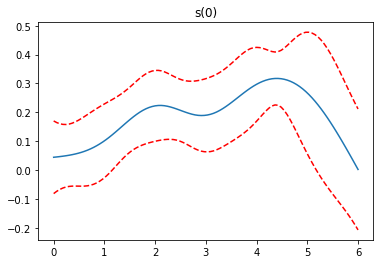

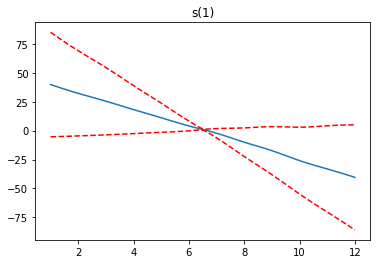

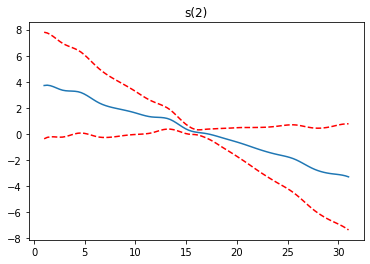

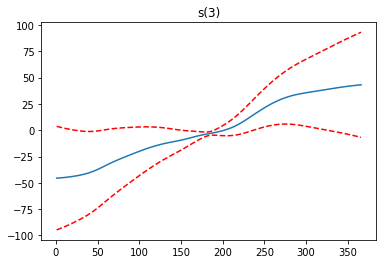

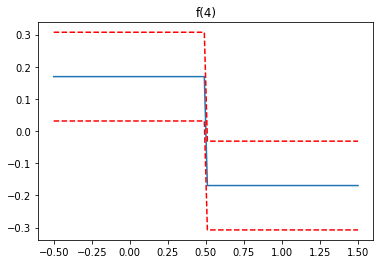

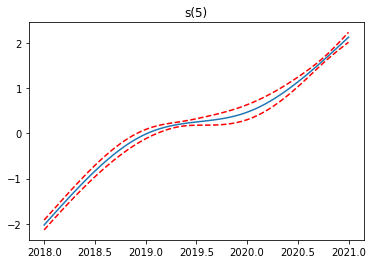

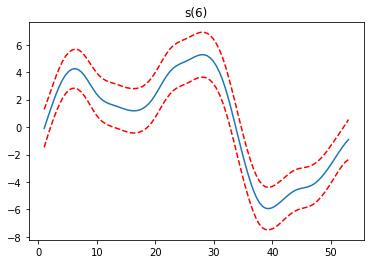

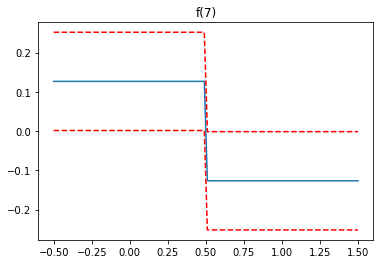

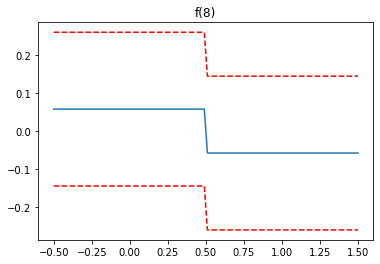

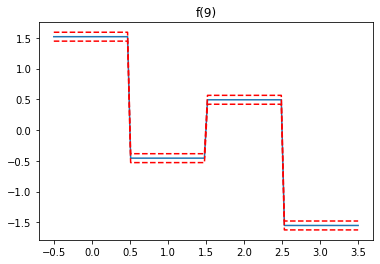

In [12]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

In [13]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     73.5498
Link Function:                     IdentityLink Log Likelihood:                                -12167.1449
Number of Samples:                         5844 AIC:                                            24483.3894
                                                AICc:                                           24485.3422
                                                GCV:                                                2.7186
                                                Scale:                                              2.6571
                                                Pseudo R-Squared:                                   0.7216
Feature Function                  Lam

C:\Users\s_dojh99\AppData\Local\Temp/ipykernel_7340/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [14]:
df_test = dfByDateRange(datetime(year=2022,month=1,day=1),datetime(year=2022,month=11,day=30))

In [15]:
df_testX = preprocess(df_test,'./data/holiday_test.csv')

In [16]:
prediction = gam.predict(df_testX)
prediction[prediction<0.01] = 0.01

In [17]:
n_dates = len(prediction)//4
df_submission = pd.DataFrame({
    '일시':df_test['일시'].values,
    '광진구':prediction[:n_dates],
    '동대문구':prediction[n_dates:2*n_dates],
    '성동구':prediction[2*n_dates:3*n_dates],
    '중랑구':prediction[3*n_dates:]
})

In [18]:
df_submission.tail()

,일시,광진구,동대문구,성동구,중랑구
329,20221126,9.200273,7.225089,8.174208,6.130355
330,20221127,8.641722,6.666538,7.615656,5.571804
331,20221128,9.153016,7.177832,8.126951,6.083098
332,20221129,9.139036,7.163852,8.112970,6.069118
333,20221130,9.284912,7.309728,8.258846,6.214993


In [19]:
filename = f"sub_gam_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
print(filename)
df_submission.to_csv(f"./out/{filename}", index=False)

sub_gam_20221203_184055.csv


In [31]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

trainX = df_processed[df_processed['year']!=2021].drop(['y'],axis=1)
trainy = df_processed[df_processed['year']!=2021]['y']
valX = df_processed[df_processed['year']==2021].drop(['y'],axis=1)
valY = df_processed[df_processed['year']==2021]['y']

2.3188930123287665


In [ ]:
randomForest = RandomForestRegressor(criterion='mse',n_estimators=1000)

randomForest.fit(trainX,trainy)
val_yhat=randomForest.predict(valX)
mae = np.mean(np.abs(val_yhat-valY.values))
print(mae)

In [32]:
extratrees = ExtraTreesRegressor(criterion='mse',n_estimators=1000)

extratrees.fit(trainX,trainy)
val_yhat=extratrees.predict(valX)
mae = np.mean(np.abs(val_yhat-valY.values))
print(mae)

2.30780767260274
